## Data
we have decided for now to work with much more simpler dataset called C50
### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import sys
sys.path.append("../")
from PythonCode.preprocess.preprocess import *
from PythonCode.preprocess.complexStyleFeatures import *
from PythonCode.preprocess.simpleStyleFeatures import *
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
stop_words = stopwords.words('english')
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yosef\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = load_data("../Data/C50/C50train",50)
df

,author_name,book_name,book_text
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...
1,AaronPressman,120600newsML.txt,The U.S. Postal Service announced Wednesday a ...
2,AaronPressman,120683newsML.txt,Elementary school students with access to the ...
3,AaronPressman,136958newsML.txt,An influential Internet organisation has backe...
4,AaronPressman,137498newsML.txt,An influential Internet organisation has backe...
...,...,...,...
2495,WilliamKazer,28223newsML.txt,China's central bank chief has said that infla...
2496,WilliamKazer,282935newsML.txt,"China ushered in 1997, a year it has hailed as..."
2497,WilliamKazer,287736newsML.txt,China issued tough new rules on the handling o...
2498,WilliamKazer,289747newsML.txt,China will avoid bold moves in tackling its ai...


## Topic Exploration

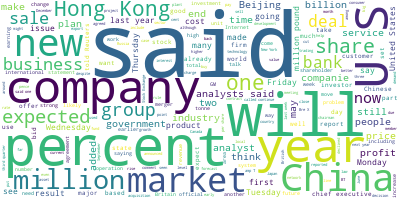

In [89]:
from wordcloud import WordCloud
long_string = ','.join(list(df['book_text'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [3]:
ignore_words = stop_words + ["said"]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))# removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in ignore_words] for doc in texts]


In [4]:
data_words = list(sent_to_words(df["book_text"].values.tolist()))
data_words = remove_stopwords(data_words)
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

In [5]:
num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"year" + 0.008*"would" + 0.007*"percent" + 0.006*"china" + '
  '0.005*"million" + 0.005*"new" + 0.004*"one" + 0.004*"also" + '
  '0.004*"company" + 0.004*"market"'),
 (1,
  '0.007*"percent" + 0.007*"would" + 0.007*"year" + 0.006*"million" + '
  '0.006*"company" + 0.005*"billion" + 0.005*"new" + 0.004*"market" + '
  '0.004*"china" + 0.004*"analysts"'),
 (2,
  '0.008*"percent" + 0.008*"million" + 0.006*"year" + 0.006*"would" + '
  '0.005*"market" + 0.005*"company" + 0.004*"one" + 0.004*"bank" + 0.004*"new" '
  '+ 0.004*"analysts"'),
 (3,
  '0.008*"would" + 0.006*"percent" + 0.006*"million" + 0.006*"year" + '
  '0.005*"new" + 0.005*"market" + 0.004*"china" + 0.004*"also" + '
  '0.004*"company" + 0.003*"one"'),
 (4,
  '0.007*"million" + 0.007*"year" + 0.006*"company" + 0.006*"percent" + '
  '0.006*"would" + 0.005*"billion" + 0.004*"new" + 0.004*"market" + '
  '0.004*"one" + 0.004*"analysts"')]


In [6]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, f'./ldavis_prepared_{str(num_topics)}.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008699 -0.002603       1        1  27.745696
4     -0.001262  0.006307       2        1  20.478496
0     -0.000538 -0.005813       3        1  19.797631
1      0.001925  0.004288       4        1  16.880901
3     -0.008824 -0.002179       5        1  15.097276, topic_info=           Term         Freq        Total Category  logprob  loglift
297       would  4920.000000  4920.000000  Default  30.0000  30.0000
5304       hong  1764.000000  1764.000000  Default  29.0000  29.0000
5307       kong  1752.000000  1752.000000  Default  28.0000  28.0000
722     billion  2929.000000  2929.000000  Default  27.0000  27.0000
82          new  3389.000000  3389.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
355   companies   234.030041  1835.711734   Topic5  -6.1480  -0.1691
761    expected   217.705963  1617.075578   Topic5  -6.2203  -0.1146
1090      first   221.928464  1917.725883   Topic5  -6.2011  -0.2659
1417      share   220.741891  1931.534683   Topic5  -6.2064  -0.2784
53        group   218.507913  1888.169597   Topic5  -6.2166  -0.2659

[456 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
12463      1  0.472522      aaa
15540      1  0.223812    abbey
15540      2  0.386584    abbey
15540      3  0.203465    abbey
15540      4  0.091559    abbey
...      ...       ...      ...
9001       5  0.126682   yellow
9002       1  0.557227  zollars
9002       3  0.185742  zollars
9002       4  0.185742  zollars
9002       5  0.185742  zollars

[1320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

In [19]:
new_topics = lda_model[corpus]
col_res = []
for i,topic in enumerate(new_topics):
    col_res.append(max(topic,key=lambda item:item[1])[0])
df["topic"] = pd.Series(col_res)

In [20]:
df

,author_name,book_name,book_text,topic
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...,2
1,AaronPressman,120600newsML.txt,The U.S. Postal Service announced Wednesday a ...,2
2,AaronPressman,120683newsML.txt,Elementary school students with access to the ...,1
3,AaronPressman,136958newsML.txt,An influential Internet organisation has backe...,2
4,AaronPressman,137498newsML.txt,An influential Internet organisation has backe...,2
...,...,...,...,...
2495,WilliamKazer,28223newsML.txt,China's central bank chief has said that infla...,2
2496,WilliamKazer,282935newsML.txt,"China ushered in 1997, a year it has hailed as...",0
2497,WilliamKazer,287736newsML.txt,China issued tough new rules on the handling o...,0
2498,WilliamKazer,289747newsML.txt,China will avoid bold moves in tackling its ai...,0


## Preprocess

In [90]:
# x_train, x_test, y_train, y_test = preprocess_pipeline("../Data/C50/C50train/", 50, complex_style_features_extraction, True, data_filter=chunking)

In [105]:
print("sentences number:\n")
print(df["book_text"].swifter.apply(lambda s: len(nltk.tokenize.sent_tokenize(s))).describe())
print("\nword(whitespace based) number:\n")
print(df["book_text"].swifter.apply(lambda s: len(s.split(" "))).describe())
print("\nword(word_tokanize based) number:\n")
print(df["book_text"].swifter.apply(lambda s: len(nltk.tokenize.word_tokenize(s))).describe())

sentences number:



Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

count    2500.00000
mean       21.55760
std         6.40224
min         2.00000
25%        18.00000
50%        21.00000
75%        25.00000
max        58.00000
Name: book_text, dtype: float64

word(whitespace based) number:



Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

count    2500.00000
mean      487.59120
std       131.77241
min        50.00000
25%       409.00000
50%       490.50000
75%       556.25000
max      1415.00000
Name: book_text, dtype: float64

word(word_tokanize based) number:



Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

count    2500.000000
mean      574.889600
std       156.444721
min        57.000000
25%       482.750000
50%       577.000000
75%       656.000000
max      1610.000000
Name: book_text, dtype: float64


In [10]:
df = num_sentences_based_chucking(df,10)
df

,author_name,book_name,book_text
0,AaronPressman,106247newsML.txt,The Internet may be overflowing with new techn...
0,AaronPressman,106247newsML.txt,In third place were crooks who sell computer e...
1,AaronPressman,120600newsML.txt,The U.S.Postal Service announced Wednesday a p...
1,AaronPressman,120600newsML.txt,Instead of manually calculating postage rates ...
1,AaronPressman,120600newsML.txt,Earlier experience tells us that this is a pub...
...,...,...,...
2498,WilliamKazer,289747newsML.txt,"""The problem is there is no social safety net,..."
2498,WilliamKazer,289747newsML.txt,Some economists had hoped communist leaders wo...
2499,WilliamKazer,304402newsML.txt,Communist Party chief Jiang Zemin has put his ...
2499,WilliamKazer,304402newsML.txt,Deng has not been seen in public in nearly thr...


In [11]:
from sklearn.model_selection import train_test_split
X,Y = pd.DataFrame(df[TEXT_COLUMN_LABEL], columns=[TEXT_COLUMN_LABEL]),df[AUTHOR_NAME_COLUMN_NAME]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [12]:
x_train.shape

(5412, 1)

In [13]:
simple_train,simple_test = simple_style_features_extraction(x_train,x_test)
complex_train,complex_test = complex_style_features_extraction(x_train,x_test)
x_train = pd.concat([simple_train,complex_train])
x_test = pd.concat([simple_test,complex_test])
x_train

C:\ProgramData\Anaconda3\lib\site-packages\swifter\swifter.py:36: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5412 [00:00<?, ?it/s]

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
..\PythonCode\preprocess\simpleStyleFeatures.py:66: DeprecationWarning: The default dtype for empty Series will be 'ob

ZeroDivisionError: division by zero

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

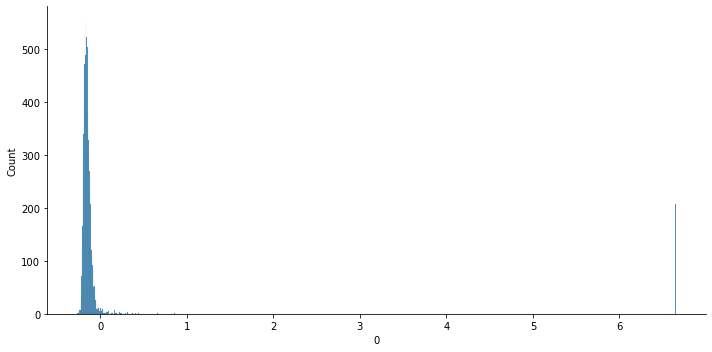

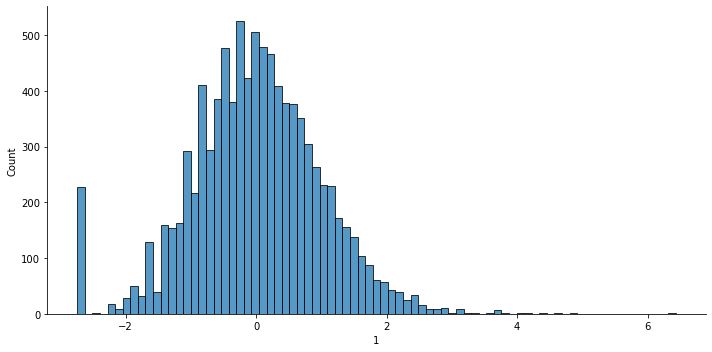

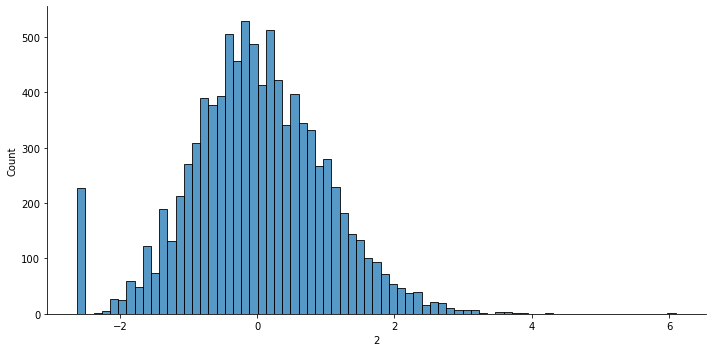

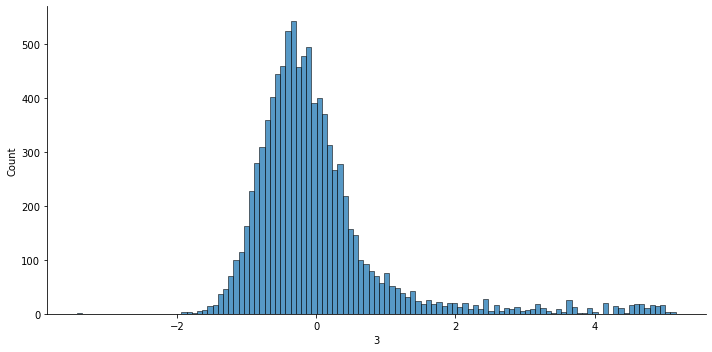

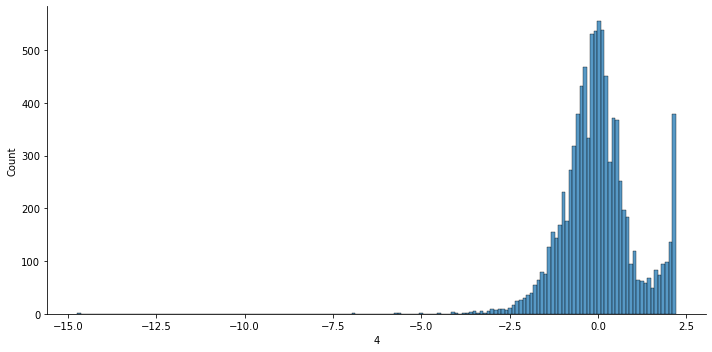

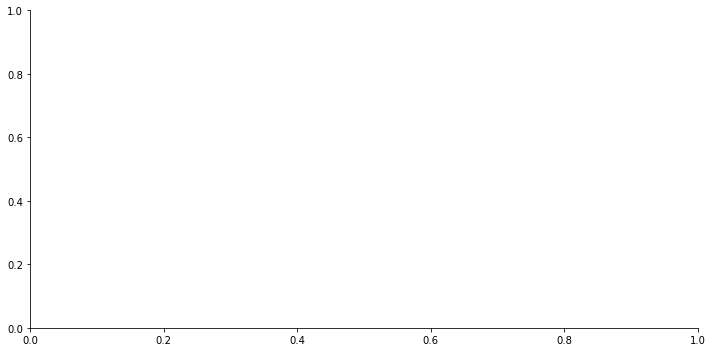

In [54]:
NUM_IN_ROW = 3
columns = x_train.columns
# fig, axs = plt.subplots(len(columns)//NUM_IN_ROW+1,NUM_IN_ROW,figsize=(20,20))
# ax=axs[i//NUM_IN_ROW,i%NUM_IN_ROW]
# fig.suptitle('Features distrabution')
for i,col_name in enumerate(x_train.columns):
    sns.displot(data=x_train,x=col_name,kind="hist",aspect=2)


## Models

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import cPickle

classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Xgboost": XGBClassifier(),
    "RBF SVM": SVC(gamma=2, C=1),
    "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=40),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
}

In [ ]:
for name,classifier in classifiers.items():
    print(f"========== {name} ===========")
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(y_test)
    print(classifcation_report(y_test,y_pred))
    with open(f'{name}.pkl', 'wb') as file:
        cPickle.dump(classifier, file)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPool2D

model = Sequential()
model.add(Dense(50,input_shape=()))
model.add(Dense(50))
model.add(Dense(50))
model.compile(loss="",optimizer='adam',metrics=['accuracy',])
model.summary()

In [ ]:
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)